In [1]:
%config Completer.use_jedi = False
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,f1_score,roc_auc_score
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler, NeighbourhoodCleaningRule
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


def data_import_save(url =  "https://raw.githubusercontent.com/alura-cursos/ML_Classificacao_por_tras_dos_panos/main/Dados/Customer-Churn.csv", 
                         savepath = '..\\src\\data\\churn_detection_raw.csv'):
    df_temp = pd.read_csv(url)
    df_temp.to_csv(savepath)
    return df_temp

# a function that returns each colum unique values, whit the amount of uniques
def info_dados(df):
    columns = df.columns
    for column in columns:
        print(f'Column: {column}')
        print(df[column].unique(), f'Shape: {df[column].unique().shape[0]}', df[column].dtype)
        
# procura coluna com numeros inteiros que tenham apenas zeros e uns e os transforma em uint8
def zeroum_to_uint8(df):
    for column in df.columns:
        if (str(df[column].dtype).startswith('int') or str(df[column].dtype).startswith('float')) and df[column].unique().sum() == 1:
            df[column] = df[column].astype('uint8')
        

In [2]:
df_raw = data_import_save()
df = pd.get_dummies(df_raw,drop_first=True)
df

,Maior65Anos,MesesDeContrato,ContaMensal,Conjuge_Sim,Dependentes_Sim,TelefoneFixo_Sim,VariasLinhasTelefonicas_SemServicoTelefonico,VariasLinhasTelefonicas_Sim,ServicoDeInternet_FibraOptica,ServicoDeInternet_Nao,...,TVaCabo_Sim,StreamingDeFilmes_SemServicoDeInternet,StreamingDeFilmes_Sim,TipoDeContrato_Mensalmente,TipoDeContrato_UmAno,PagamentoOnline_Sim,FormaDePagamento_ChequeDigital,FormaDePagamento_ChequePapel,FormaDePagamento_DebitoEmConta,Churn_Sim
0,0,1,29.85,1,0,0,1,0,0,0,...,0,0,0,1,0,1,1,0,0,0
1,0,34,56.95,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,0,2,53.85,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,1,0,1
3,0,45,42.30,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,2,70.70,0,0,1,0,0,1,0,...,0,0,0,1,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,24,84.80,1,1,1,0,1,0,0,...,1,0,1,0,1,1,0,1,0,0
7039,0,72,103.20,1,1,1,0,1,1,0,...,1,0,1,0,1,1,0,0,0,0
7040,0,11,29.60,1,1,0,1,0,0,0,...,0,0,0,1,0,1,1,0,0,0
7041,1,4,74.40,1,0,1,0,1,1,0,...,0,0,0,1,0,1,0,1,0,1


In [3]:
info_dados(df_raw)

Column: Maior65Anos
[0 1] Shape: 2 int64
Column: Conjuge
['Sim' 'Nao'] Shape: 2 object
Column: Dependentes
['Nao' 'Sim'] Shape: 2 object
Column: MesesDeContrato
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39] Shape: 73 int64
Column: TelefoneFixo
['Nao' 'Sim'] Shape: 2 object
Column: VariasLinhasTelefonicas
['SemServicoTelefonico' 'Nao' 'Sim'] Shape: 3 object
Column: ServicoDeInternet
['DSL' 'FibraOptica' 'Nao'] Shape: 3 object
Column: SegurancaOnline
['Nao' 'Sim' 'SemServicoDeInternet'] Shape: 3 object
Column: BackupOnline
['Sim' 'Nao' 'SemServicoDeInternet'] Shape: 3 object
Column: SeguroNoDispositivo
['Nao' 'Sim' 'SemServicoDeInternet'] Shape: 3 object
Column: SuporteTecnico
['Nao' 'Sim' 'SemServicoDeInternet'] Shape: 3 object
Column: TVaCabo
['Nao' 'Sim' 'SemServicoDeInternet'] Shape: 3 object
Column: Streamin

é importante destacar que os clientes que não tem serviço online automaticamente não teriam os serviços relacionados e portanto poderiam se relacionar de forma direta ao "Não" dos dados.  
Uma análise de correlação entre essa variável "Sem serviço de internet" e o Churn pode ajudar a decidir

In [4]:
df_raw.describe(include = "all")

,Maior65Anos,Conjuge,Dependentes,MesesDeContrato,TelefoneFixo,VariasLinhasTelefonicas,ServicoDeInternet,SegurancaOnline,BackupOnline,SeguroNoDispositivo,SuporteTecnico,TVaCabo,StreamingDeFilmes,TipoDeContrato,PagamentoOnline,FormaDePagamento,ContaMensal,Churn
count,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,NaN,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,2
top,NaN,Nao,Nao,NaN,Sim,Nao,FibraOptica,Nao,Nao,Nao,Nao,Nao,Nao,Mensalmente,Sim,ChequeDigital,NaN,Nao
freq,NaN,3641,4933,NaN,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,NaN,5174
mean,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


In [5]:
print('A quantidade total de nulos nesse banco de dados é: ',df.isna().sum().sum())

A quantidade total de nulos nesse banco de dados é:  0


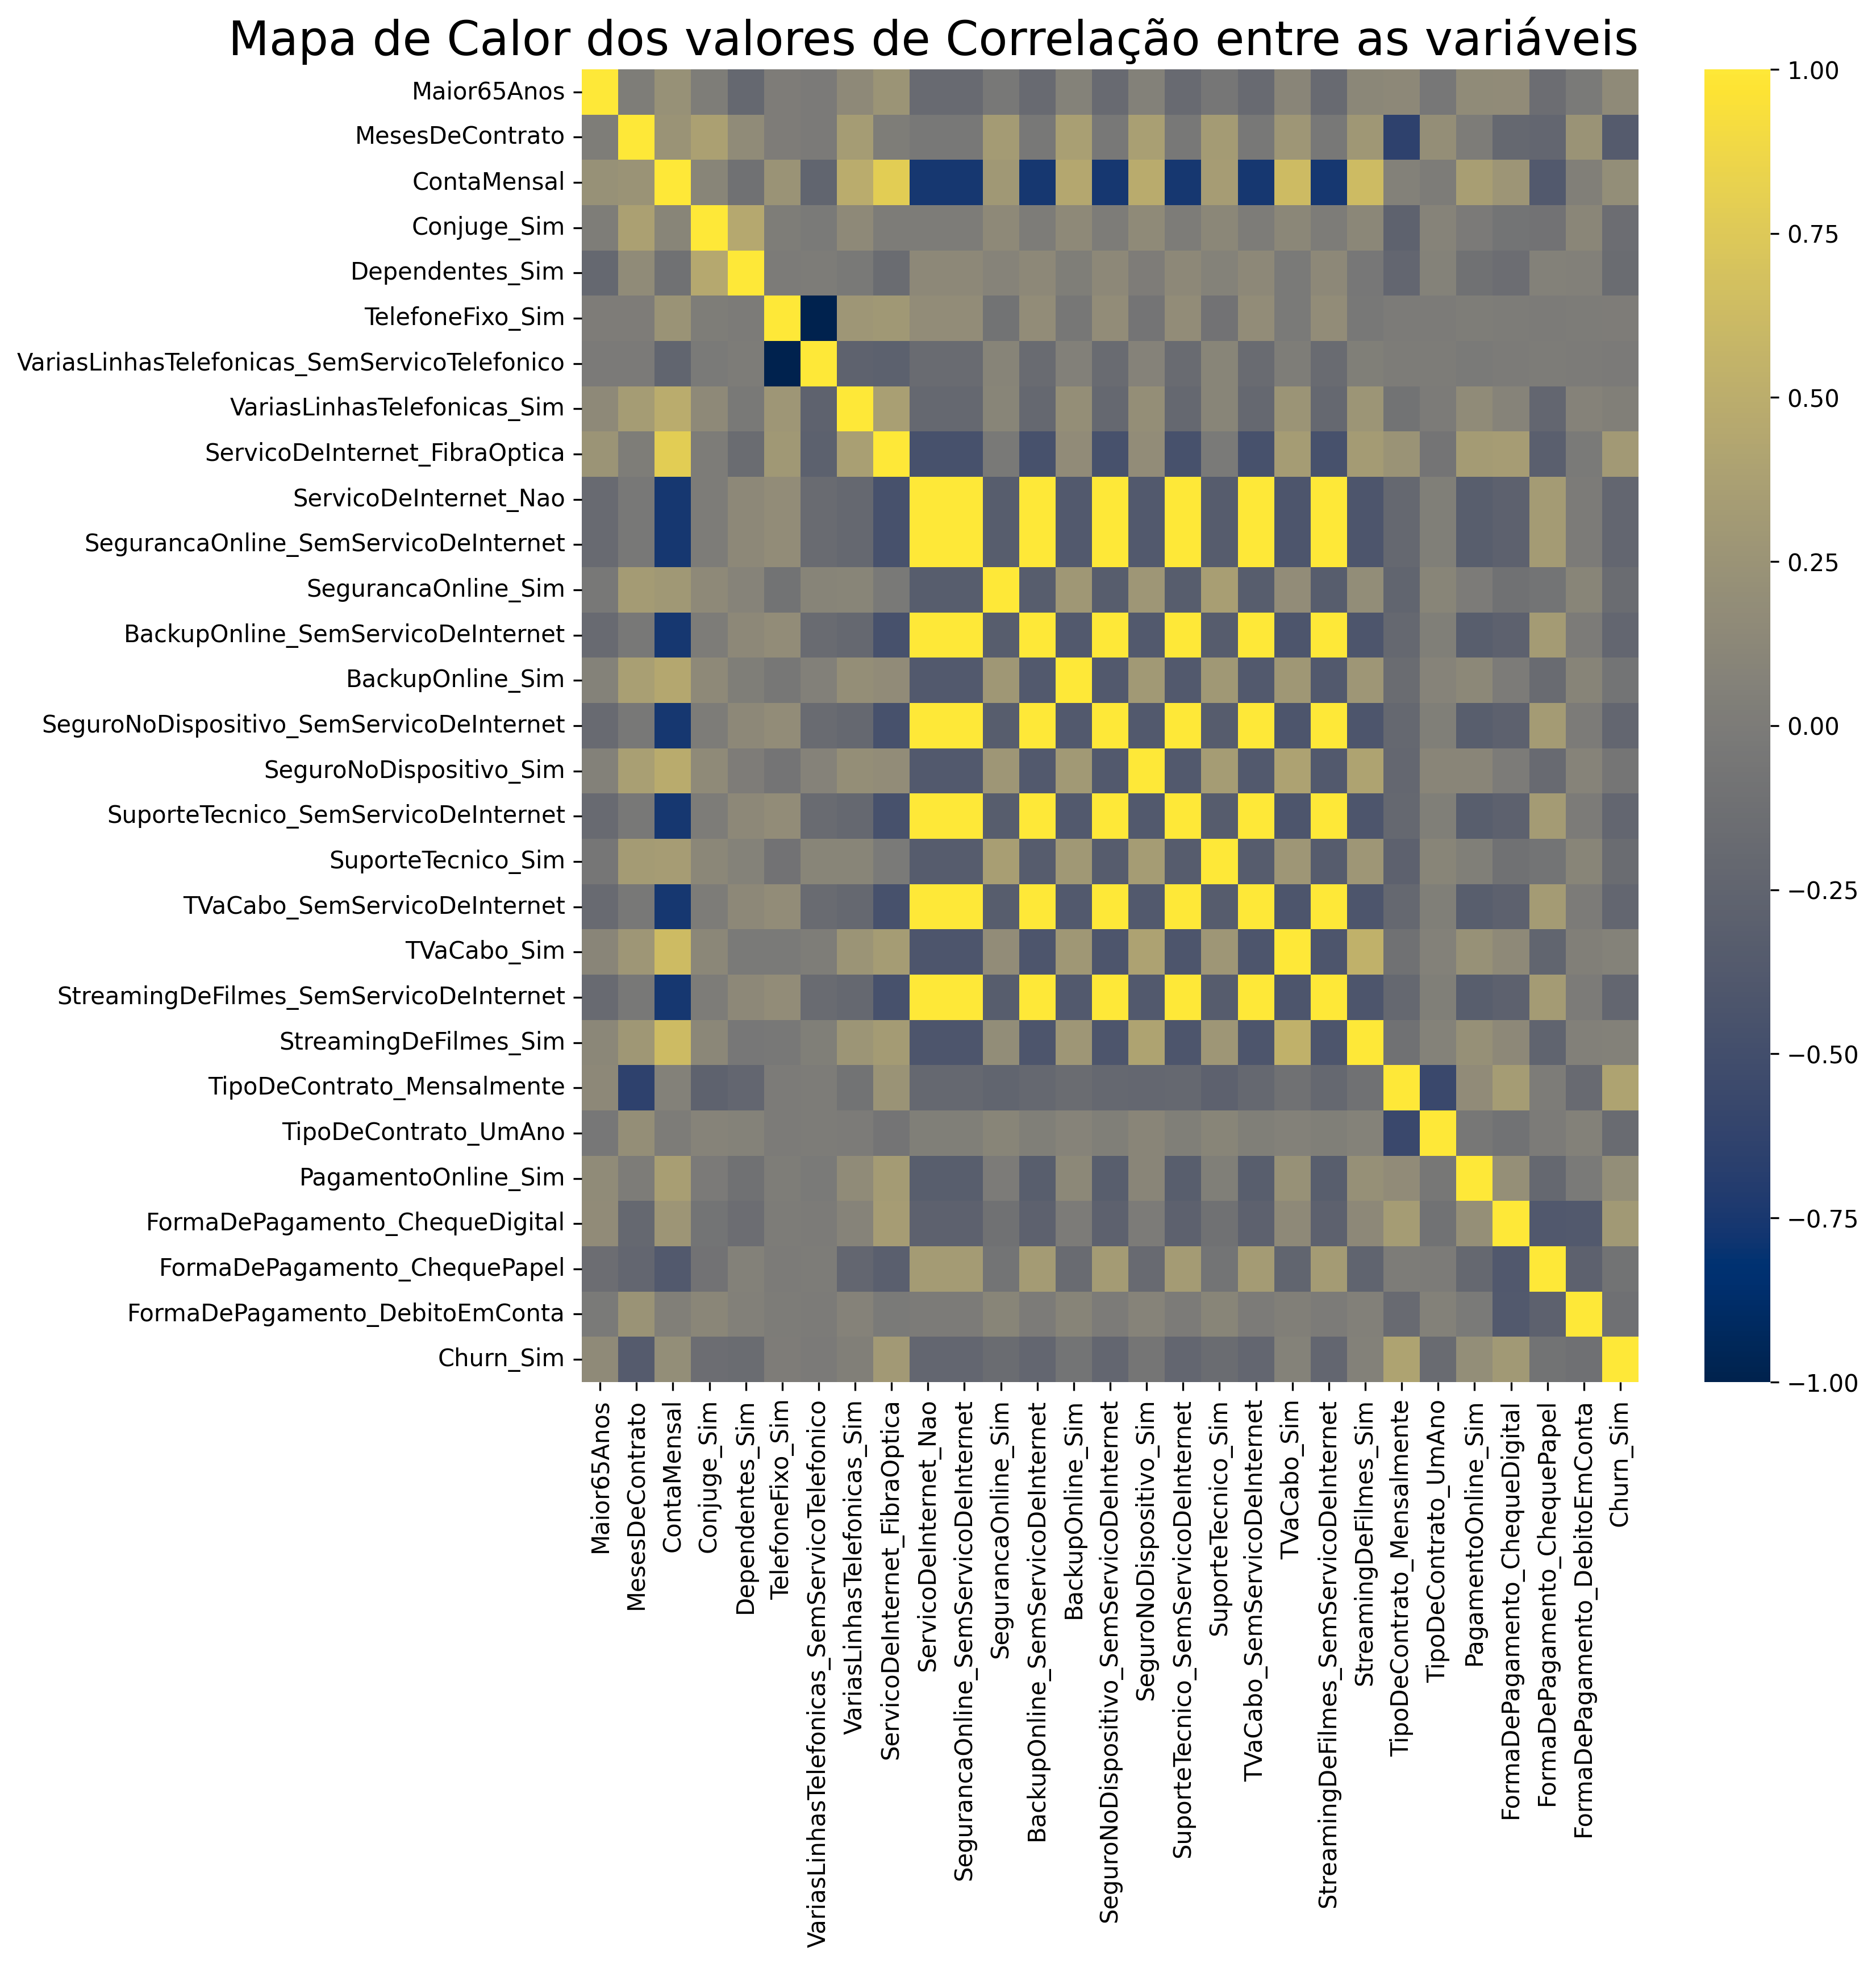

In [6]:
plt.figure(figsize=(10,10), dpi=300)
fig = sns.heatmap(df.corr(),xticklabels=1, yticklabels=1, cmap='cividis' )
plt.savefig('../figs/heatmap.png')
plt.title('Mapa de Calor dos valores de Correlação entre as variáveis',fontdict={'fontsize':20}, loc='right')
plt.show()

A pesar de de apresentarem uma correlação fraca +- 0,2, há uma diferença entre o cliente não ter o serviço e ele ter e apenas optar por não assinar o serviço.

In [7]:
df

,Maior65Anos,MesesDeContrato,ContaMensal,Conjuge_Sim,Dependentes_Sim,TelefoneFixo_Sim,VariasLinhasTelefonicas_SemServicoTelefonico,VariasLinhasTelefonicas_Sim,ServicoDeInternet_FibraOptica,ServicoDeInternet_Nao,...,TVaCabo_Sim,StreamingDeFilmes_SemServicoDeInternet,StreamingDeFilmes_Sim,TipoDeContrato_Mensalmente,TipoDeContrato_UmAno,PagamentoOnline_Sim,FormaDePagamento_ChequeDigital,FormaDePagamento_ChequePapel,FormaDePagamento_DebitoEmConta,Churn_Sim
0,0,1,29.85,1,0,0,1,0,0,0,...,0,0,0,1,0,1,1,0,0,0
1,0,34,56.95,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,0,2,53.85,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,1,0,1
3,0,45,42.30,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,2,70.70,0,0,1,0,0,1,0,...,0,0,0,1,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,24,84.80,1,1,1,0,1,0,0,...,1,0,1,0,1,1,0,1,0,0
7039,0,72,103.20,1,1,1,0,1,1,0,...,1,0,1,0,1,1,0,0,0,0
7040,0,11,29.60,1,1,0,1,0,0,0,...,0,0,0,1,0,1,1,0,0,0
7041,1,4,74.40,1,0,1,0,1,1,0,...,0,0,0,1,0,1,0,1,0,1


Churn_Sim,0,1
Maior65Anos,0.583187,0.416813
Conjuge_Sim,0.803351,0.196649
Dependentes_Sim,0.845498,0.154502
TelefoneFixo_Sim,0.732904,0.267096
VariasLinhasTelefonicas_SemServicoTelefonico,0.750733,0.249267
VariasLinhasTelefonicas_Sim,0.713901,0.286099
ServicoDeInternet_FibraOptica,0.581072,0.418928
ServicoDeInternet_Nao,0.925950,0.074050
SegurancaOnline_SemServicoDeInternet,0.925950,0.074050
SegurancaOnline_Sim,0.853888,0.146112


In [238]:
A = df.select_dtypes(include = 'uint8').groupby(df.Churn_Sim, sort = False).sum()
A = A.div(df.select_dtypes(include = 'uint8').sum(axis=0), axis=1).T
plx.bar(orientation='h', data_frame=A.drop('Churn_Sim',axis=0),color_continuous_scale=['aliceblue', 'white'])

In [229]:
from matplotlib import colors
import webcolors

def find_closest_color(hex_color):
    # Convert hex color code to RGB tuple
#     rgb_color = webcolors.hex_to_rgb(hex_color)

#     # Find the nearest named color for the RGB color tuple
#     try:
#         color_name = webcolors.rgb_to_name(rgb_color, spec='css3')
#     except ValueError:
#         # If the color is not in the CSS3 specification, find the closest named color
    min_distance = float('inf')
    closest_name = None
    clist = []
    for name, hex_value in colors.CSS4_COLORS.items():
        rgb_color = webcolors.hex_to_rgb(hex_color)
        rgb_value = colors.hex2color(hex_value)
        distance = sum([((a - b) ** 2) for a, b in zip(rgb_value, rgb_color)])
        
        if distance < min_distance:
            clist.append(name)
            min_distance = distance
#             print(clist[-1])
            closest_name = name
            color_name = clist[0]

    return clist

In [147]:
get_cmap_colors()

['#440154',
 '#440256',
 '#450457',
 '#450559',
 '#46075a',
 '#46085c',
 '#460a5d',
 '#460b5e',
 '#470d60',
 '#470e61',
 '#471063',
 '#471164',
 '#471365',
 '#481467',
 '#481668',
 '#481769',
 '#48186a',
 '#481a6c',
 '#481b6d',
 '#481c6e',
 '#481d6f',
 '#481f70',
 '#482071',
 '#482173',
 '#482374',
 '#482475',
 '#482576',
 '#482677',
 '#482878',
 '#482979',
 '#472a7a',
 '#472c7a',
 '#472d7b',
 '#472e7c',
 '#472f7d',
 '#46307e',
 '#46327e',
 '#46337f',
 '#463480',
 '#453581',
 '#453781',
 '#453882',
 '#443983',
 '#443a83',
 '#443b84',
 '#433d84',
 '#433e85',
 '#423f85',
 '#424086',
 '#424186',
 '#414287',
 '#414487',
 '#404588',
 '#404688',
 '#3f4788',
 '#3f4889',
 '#3e4989',
 '#3e4a89',
 '#3e4c8a',
 '#3d4d8a',
 '#3d4e8a',
 '#3c4f8a',
 '#3c508b',
 '#3b518b',
 '#3b528b',
 '#3a538b',
 '#3a548c',
 '#39558c',
 '#39568c',
 '#38588c',
 '#38598c',
 '#375a8c',
 '#375b8d',
 '#365c8d',
 '#365d8d',
 '#355e8d',
 '#355f8d',
 '#34608d',
 '#34618d',
 '#33628d',
 '#33638d',
 '#32648e',
 '#32658e',
 '#3

In [230]:
find_closest_color('#2e6e8e')

['aliceblue', 'azure', 'white']

In [234]:
cores = get_cmap_colors()
a = []
for i in cores:
#     print(find_closest_color(i), '-', i)
    a.append(str(find_closest_color(i)))
a[-1]
    

"['aliceblue', 'azure', 'cornsilk', 'floralwhite', 'ivory', 'white']"

In [64]:
webcolors.CSS3_NAMES_TO_HEX

{'aliceblue': '#f0f8ff',
 'antiquewhite': '#faebd7',
 'aqua': '#00ffff',
 'aquamarine': '#7fffd4',
 'azure': '#f0ffff',
 'beige': '#f5f5dc',
 'bisque': '#ffe4c4',
 'black': '#000000',
 'blanchedalmond': '#ffebcd',
 'blue': '#0000ff',
 'blueviolet': '#8a2be2',
 'brown': '#a52a2a',
 'burlywood': '#deb887',
 'cadetblue': '#5f9ea0',
 'chartreuse': '#7fff00',
 'chocolate': '#d2691e',
 'coral': '#ff7f50',
 'cornflowerblue': '#6495ed',
 'cornsilk': '#fff8dc',
 'crimson': '#dc143c',
 'cyan': '#00ffff',
 'darkblue': '#00008b',
 'darkcyan': '#008b8b',
 'darkgoldenrod': '#b8860b',
 'darkgray': '#a9a9a9',
 'darkgrey': '#a9a9a9',
 'darkgreen': '#006400',
 'darkkhaki': '#bdb76b',
 'darkmagenta': '#8b008b',
 'darkolivegreen': '#556b2f',
 'darkorange': '#ff8c00',
 'darkorchid': '#9932cc',
 'darkred': '#8b0000',
 'darksalmon': '#e9967a',
 'darkseagreen': '#8fbc8f',
 'darkslateblue': '#483d8b',
 'darkslategray': '#2f4f4f',
 'darkslategrey': '#2f4f4f',
 'darkturquoise': '#00ced1',
 'darkviolet': '#9400d3

In [ ]:
#Plot doas variáveis apenas com sim e não para ver se elas dividem o dataset, DESBALANCEADO

# transforma as variáveis zero e um para o formato unint8
zeroum_to_uint8(df)

# Cria um agrupamento de todas as variáveis categoricas
A = df.select_dtypes(include = 'uint8').groupby(df.Churn_Sim, sort = False).sum()
A = A.div(df.select_dtypes(include = 'uint8').sum(axis=0), axis=1).T


sns.set_style('whitegrid')
sns.axisgrid
A.plot(kind="barh", rot=0, stacked=True)
plt.set_cmap('viridis')
plt.tick_params(labelsize=8)
plt.xlabel('Fração de cada Categoria')


Text(0.5, 0, 'Fração de cada Categoria')

# Balanceamento de dados

O banco de dados está desbalanceado quanto ao Churn, um balanceamento por oversampling será feito com o SMOTE

In [ ]:
# conferindo o balanceamento da target
df.Churn_Sim.value_counts()

In [ ]:
y = df.Churn_Sim
X = df.drop('Churn_Sim', axis=1)

In [53]:
plt.get_cmap('cividis')

(0.0, 0.138068, 0.311105, 1.0)

In [ ]:
smt = SMOTE(random_state=123)  
X, y = smt.fit_resample(X, y)

In [ ]:
# conferindo a atarget balanceada pelo obersampling via SMOTE
y.value_counts()

In [ ]:
zeroum_to_uint8(X)

In [63]:
to_rgb(#da70d6)

SyntaxError: '(' was never closed (3333610836.py, line 1)

In [ ]:
# Agrupa os dados binados e os somas de acordo com a categoria, dividindo em seguida para normalizar os valores
A = X.select_dtypes(include = 'uint8').groupby([y], sort = False).sum()
A = A.div(X.select_dtypes(include = 'uint8').sum(axis=0), axis=1)
A = A.T
# Faz o plot dos dados em barras horizontais de forma normalizada para observar a divisão do targuet entre os dados
A.plot(kind="barh", rot=0, stacked=True, )
plt.xticks(rotation = 90)
plt.xlabel('Fração de cada Categoria')

plt.show()

In [60]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex, to_rgb
import numpy as np

def find_closest_name(col):
    rv, gv, bv = to_rgb(col)
    min_colors = {}
    for col in webcolors.CSS3_HEX_TO_NAMES:
        rc, gc, bc = to_rgb(col)
        min_colors[(rc - rv) ** 2 + (gc - gv) ** 2 + (bc - bv) ** 2] = col
    closest = min(min_colors.keys())
    return min_colors[closest], np.sqrt(closest)

viridis = plt.get_cmap('viridis')
for i in range(256):
    closest_name, dist = find_closest_name(viridis(i))
    print(f'{i:3d} {to_hex((rv, gv, bv))} closest:{closest_name})  dist:{dist:.3f}')

NameError: name 'rv' is not defined

In [ ]:
# A = X.select_dtypes(exclude = 'uint8').groupby([y], sort = False).sum().div(X.select_dtypes(include = 'uint8').sum(axis=0), axis=1).T
# A.iloc[3:].plot(kind="scatter", rot=0, stacked=True, )
# plt.xticks(rotation = 90)
# plt.show()
# df.plot()

In [36]:
import matplotlib.colors
matplotlib.colors.LinearSegmentedColormap.from_list("",plt.get_cmap('cividis'))

ValueError: colors must be iterable

In [67]:
import matplotlib.pyplot as plt
import webcolors
import numpy as np

def find_closest_name(col):
    rv, gv, bv, _ = col # unpack RGB and alpha values
    min_colors = {}
    for hex, name in webcolors.CSS3_HEX_TO_NAMES.items():
        rc, gc, bc = webcolors.hex_to_rgb(hex)
        min_colors[(rc - rv) ** 2 + (gc - gv) ** 2 + (bc - bv) ** 2] = name
    closest = min(min_colors.keys())
    return min_colors[closest], np.sqrt(closest)

viridis = plt.get_cmap('viridis')
for i in range(256):
    closest_name, dist = find_closest_name(viridis(i))
    print(f'closest:{closest_name}')

closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closest:black
closes

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [56]:
import plotly.express as plx
import plotly.io as pio

fig = plx.bar(data_frame=A.drop('Churn_Sim',axis=0),orientation='h',color_discrete_sequence=[
    '#440154','#48186a','#472d7b','#424086','#3b528b','#33638d','#2c728e','#26828e','#21918c','#1fa088',
    '#28ae80','#3fbc73','#5ec962','#84d44b','#addc30','#d8e219','#fde725'])
pio.write_image(fig, '../figs/barplot_desbalanceado.png',width=900, height=600,scale=3)




In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


## KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
knn.score(X_test,y_test)

In [ ]:
print(confusion_matrix(y_test,knn.predict(X_test)))


# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Definindo a Árvore de decisão com profundidade máxima e com critério 
tree = DecisionTreeClassifier(criterion='entropy', max_depth=5)

# Treinando com os dados e avaliando a precisão com os Scores
tree.fit(X_train,y_train)
area_roc_tree = roc_auc_score(y_train,tree.predict(X_train))
f1_tree = f1_score(y_train,tree.predict(X_train))
print('A área sobre a curva ROC é {:.4f}'.format(area_roc_tree))
print('O score balanceado F1 é {:.4f}'.format(f1_tree))

In [ ]:
# Construindo a tabela com a importância de variáveis da Árvore de Decisão
a = pd.DataFrame([df.drop('Churn_Sim', axis=1).columns.tolist(),
                  tree.feature_importances_.tolist()]).T.set_index(0).sort_values(by = 1,ascending=False)
# Construindo o Gráfico
a.head(6).plot(kind = 'barh')
plt.title('Importância das variáveis para o modelo de Árvore de Decisão')
plt.xlabel('Importância relativa da variável')
plt.ylabel(None)
plt.show()

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='elasticnet',solver='saga', l1_ratio=0.1)
lr.fit(X_train,y_train)

area_roc_logistica = roc_auc_score(y_train,lr.predict(X_train))
f1_logistica = f1_score(y_train,lr.predict(X_train))

print('A área sobre a curva ROC é {:.4f}'.format(area_roc_logistica))
print('O score F1 é {:.4f}'.format(f1_logistica))

In [ ]:
# Construindo a tabela com a importância de variáveis da Árvore de Decisão
a = pd.DataFrame([df.drop('Churn_Sim', axis=1).columns.tolist(),
                  lr.coef_[0].tolist()]).T.set_index(0).sort_values(by = 1,ascending=False)
# Construindo o Gráfico
a.loc[(a[1]>=0.3)|(a[1]<=-0.3)].sort_values(1).plot(kind = 'barh')
plt.title('Importância das variáveis para o modelo de Regresão Logistica')
plt.xlabel('Importância relativa da variável')
plt.ylabel(None)
plt.show()

# Comparação entre os modelos

O objetivo da análise é detectar os clientes mais provávei de deixarem a empresa e intervir e oferecer um produto.
Para isso, uma opção é avaliar seria avaliar a precisão, porém o score F1 e a área abaixo da curva ROC são melhores.

In [ ]:
print('O score F1 do KNN é:',f1_score(y_test,knn.predict(X_test)))
print('O score F1 do Árvore de Decisão é:',f1_score(y_test,tree.predict(X_test)))
print('O score F1 da Regressão Logistica é:',f1_score(y_test,lr.predict(X_test)))

In [ ]:
print('O score AUC ROC do KNN é:',roc_auc_score(y_test,knn.predict(X_test)))
print('O score AUC ROC do Árvore de Decisão é:',roc_auc_score(y_test,tree.predict(X_test)))
print('O score F1 da Regressão Logistica é:',roc_auc_score(y_test,lr.predict(X_test)))

Nas duas métricas o melhor modelo foi o KNN e o mesmo podeá fazer a previsão se um novo cliente vai deixar a empresa.
Porém a Regressão logistica e a árvore de decisão podem dar importâncias de variáveis, que podem fornecer dias de o porquê o cliente deixa a empresa.

## Análise de Churn em uma Empresa de Telefonia e Internet

Este é um estudo de caso sobre o problema de churn em uma empresa de telefonia e internet. O churn é a taxa de perda de clientes que cancelam seus serviços, e é um problema crítico que pode afetar negativamente a receita e a imagem da marca da empresa.

A empresa oferece serviços de telefonia e internet, incluindo:
> Planos de telefone fixo, de dados móveis e de banda larga.  
> Pacotes de TV a cabo, de Streaming de Filmes e de
> Serviços de Backup Online, Segurança online e Seguro de Dispositivo 

. O objetivo é identificar os principais fatores que influenciam a taxa de churn e propor soluções para reduzir essa taxa e reter os clientes.

Os dados foram coletados a partir de várias fontes, incluindo registros de clientes, informações de faturamento e logs de chamadas de suporte. O conjunto de dados contém informações demográficas dos clientes, histórico de pagamentos e uso de serviços, bem como avaliações de satisfação e feedback de atendimento ao cliente.

A análise exploratória dos dados será realizada para identificar padrões e tendências nos dados, bem como relacionamentos entre as variáveis. Em seguida, serão aplicadas técnicas de modelagem preditiva para prever a taxa de churn e identificar os principais fatores que contribuem para essa taxa. Também serão propostas soluções para reduzir a taxa de churn, como melhorar a qualidade do serviço, ajustar preços, oferecer promoções e incentivos de fidelização, e melhorar o atendimento ao cliente.

O resultado esperado é fornecer insights valiosos sobre o problema de churn em uma empresa de telefonia e internet e fornecer recomendações práticas para reduzir essa taxa e reter os clientes.



# Inclusão da Pipeline

In [ ]:
# Substituindo sim e nao por valores boleanos
df_raw['Churn'] = df_raw.Churn.replace({'Nao':0,'Sim':1})

# separando os dados brutos em Treino e Teste Para não vazar informação nos imputs
df_train, df_test = train_test_split(df_raw, test_size=0.33, random_state=42)

# criando listas de colunas que tenham valores numeticos e objetos
lista_num = [col for col in df_raw.drop('Churn',axis=1).columns if 'object' not in str(df_raw[col].dtype)]
lista_obj = [col for col in df_raw.drop('Churn',axis=1).columns if 'object' in str(df_raw[col].dtype)]

#definindo o encoder para codificar as categorias e o scaler para normalizar as vriáveis numéricas
encoder = OneHotEncoder()
scaler = StandardScaler()

# definindo o tipo de balanceamento que será feito
balancer = SMOTE()

#definindo o modelo
model = lr

# definindo os pacos da pipeline de preprocessamento
steps_num = [('scaler',scaler)]
steps_cat = [('encoder',encoder)]

# Definindo a pipelinde de preprocessamento numerica e categorica
pipe_num = Pipeline(steps_num)
pipe_cat = Pipeline(steps_cat)

# Definindo a pipeline de preprocessamentro completa
pre_process = ColumnTransformer(transformers=[('num', pipe_num,lista_num),('cat',pipe_cat,lista_obj)])


# Definindo os pacos da pipeline
step = [('pre_process',pre_process),('balancer',balancer),('model',model)]

# Definindo a pipeline que teá os passos do step
pipe = Pipeline(step)

# Fazendo o fit nos dados de treino
pipe.fit(df_train,df_train.Churn)

# Fazendo o Predict e já retornando os scores            
score = roc_auc_score(df_test.Churn,pipe.predict(df_test))
score_f1 = f1_score(df_test.Churn,pipe.predict(df_test))
print('A área sobre a curva ROC é {:.4f}'.format(score))
print('O score F1 é {:.4f}'.format(score_f1))



## usando a Pipeline para avaliar diferentes balanceadores e diferentes modelos

In [ ]:
# separando os dados brutos em Treino e Teste Para não vazar informação nos imputs
df_train, df_test = train_test_split(df_raw, test_size=0.33, random_state=42)

# criando listas de colunas que tenham valores numeticos e objetos
lista_num = [col for col in df_raw.drop('Churn',axis=1).columns if 'object' not in str(df_raw[col].dtype)]
lista_obj = [col for col in df_raw.drop('Churn',axis=1).columns if 'object' in str(df_raw[col].dtype)]

#definindo o encoder para codificar as categorias e o scaler para normalizar as vriáveis numéricas
encoder = OneHotEncoder()
scaler = StandardScaler()

# definindo o tipo de balanceamento que será feito
balancer = SMOTE()

#definindo o modelo
model = lr

# definindo os pacos da pipeline de preprocessamento
steps_num = [('scaler',scaler)]
steps_cat = [('encoder',encoder)]

# Definindo a pipelinde de preprocessamento numerica e categorica
pipe_num = Pipeline(steps_num)
pipe_cat = Pipeline(steps_cat)

# Definindo a pipeline de preprocessamentro completa
pre_process = ColumnTransformer(transformers=[('num', pipe_num,lista_num),('cat',pipe_cat,lista_obj)])

# Definindo a lista de modelos que serão testados e definindo seus hiperparâmetros
lista_modelo = [KNeighborsClassifier(n_neighbors=10),LogisticRegression(),
                DecisionTreeClassifier(max_depth=5), RandomForestClassifier(max_depth=5),
               GradientBoostingClassifier(n_estimators=30)]

# Definindo a lista de tecnicas de balanceamento de dados a serem testadas
lista_balancer = [SMOTE(),RandomUnderSampler(),NeighbourhoodCleaningRule(n_neighbors=5)]

# Executando um loop que vai passar por diversos modelos e testar os diferentes balanceamentos e cada modelo
for model in lista_modelo:
    for balancer in lista_balancer:
        step = [('pre_process',pre_process),('balancer',balancer),('model',model)]

        pipe = Pipeline(step)
        pipe.fit(df_train,df_train.Churn)
            
        score = roc_auc_score(df_test.Churn,pipe.predict(df_test))
        score_f1 = f1_score(df_test.Churn,pipe.predict(df_test))
        print(model, balancer, 'ROC_AUC Score: {:.4f}'.format(score),'F1 Score: {:.4f}'.format(score_f1))
    print('')
        

## Usando a pipeline para realizar um gridsearch no melhor modelo e no melhor balanceamento

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Substituindo sim e nao por valores boleanos
df_raw['Churn'] = df_raw.Churn.replace({'Nao':0,'Sim':1})

# separando os dados brutos em Treino e Teste Para não vazar informação nos imputs
df_train, df_test = train_test_split(df_raw, test_size=0.33, random_state=42)

# criando listas de colunas que tenham valores numeticos e objetos
lista_num = [col for col in df_raw.drop('Churn',axis=1).columns if 'object' not in str(df_raw[col].dtype)]
lista_obj = [col for col in df_raw.drop('Churn',axis=1).columns if 'object' in str(df_raw[col].dtype)]

#definindo o encoder para codificar as categorias e o scaler para normalizar as vriáveis numéricas
encoder = OneHotEncoder()
scaler = StandardScaler()

# definindo o tipo de balanceamento que será feito
balancer = SMOTE()

#definindo o modelo
model = GradientBoostingClassifier(n_estimators=30)

# definindo os pacos da pipeline de preprocessamento
steps_num = [('scaler',scaler)]
steps_cat = [('encoder',encoder)]

# Definindo a pipelinde de preprocessamento numerica e categorica
pipe_num = Pipeline(steps_num)
pipe_cat = Pipeline(steps_cat)

# Definindo a pipeline de preprocessamentro completa
pre_process = ColumnTransformer(transformers=[('num', pipe_num,lista_num),('cat',pipe_cat,lista_obj)])


# Definindo os pacos da pipeline
step = [('pre_process',pre_process),('balancer',balancer),('model',model)]

# Definindo a pipeline que teá os passos do step
pipe = Pipeline(step)

# Definindo a lista de parâmetros
param = {'model__n_estimators':[10,50,100,200], 'model__max_depth':[1,2,3,4]}

# Definindo o Gridsearch com score F1
gcv = GridSearchCV(pipe,scoring='f1',n_jobs=-1, param_grid=param)

# Treinando o gridsearch com dados de treino
gcv.fit(df_train,df_train.Churn)

In [ ]:
# Retornando a melhor combinanção dos parâmetros avaliados
print('A melhor profundidade foi de ',gcv.best_params_['model__max_depth'])
print('O melhor numero de estimadores foi de ',gcv.best_params_['model__n_estimators'])

# definindo o melhor modelo
melhor_modelo = gcv.best_estimator_

# avaliando o melhor modelo
print('O score F1 dos dados totais de treino é {:.4f}'.format(f1_score(df_train.Churn,melhor_modelo.predict(df_train))))
print('O score F1 dos dados de teste é {:.4f}'.format(f1_score(df_test.Churn,melhor_modelo.predict(df_test))))


## Usando SHAP para retornar a importância das variáveis na previsão

In [ ]:
import shap

In [ ]:
# definindo o modelo de explicação do tipo gradient boost de arvores
explainer = shap.TreeExplainer(melhor_modelo['model'])

# separando os dados brutos em Treino e Teste Para não vazar informação nos imputs
df_train, df_test = train_test_split(df_raw, test_size=0.33, random_state=42)

# separando X e y dos dados de treino e aplicando o preprocessamento da pipeline em X
X = melhor_modelo['pre_process'].transform(df_train)
y = df_train.Churn

# retornando os valores shap do explicador
shap_values = explainer.shap_values(X,y)

# Definindo o nome das variaveis e retornando um gráfico violino das previsões em função do Churn
feature_names=melhor_modelo['pre_process'].get_feature_names_out()
fig = shap.summary_plot(
    shap_values, 
    X, 
    feature_names = feature_names,
    plot_type='dot',
    plot_size=(12,12),
    show=False,
    cmap = "cividis")
plt.title('Importancia de variável para todas as previsões de treino', loc='right',fontdict={'fontsize':20})
plt.xlabel('Impacto da variável na resposta do modelo')
plt.ylabel('Cliente Saiu ou não Saiu')
plt.show(fig)




In [ ]:
shap.force_plot(
    explainer.expected_value, 
    shap_values[1,:], 
    X[1,:], 
    matplotlib=True, 
    feature_names=melhor_modelo['pre_process'].get_feature_names_out(), 
    text_rotation=80 )